In [17]:
import os
import time
import pandas as pd
import numpy as np
import networkx as nx
import collections
from scipy import sparse as sp
from scipy.stats import rankdata

import itertools
from itertools import combinations, combinations_with_replacement, cycle
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from util import *

import colorcet as cc

In [18]:
hemibrain_version = "v1.2.1"
log_msg("Hemibrain data set being used:", hemibrain_version)

preproc_dir = "oviIN/preprocessed-" + hemibrain_version
preproc_nodes = "preprocessed_nodes.csv"
preproc_centroids = "x"
preproc_edges = "preprocessed_undirected_edges.csv"

hemibrain_dir = "oviIN/clustering_" + hemibrain_version
hemibrain_nodes = "inputsoutputs_key.txt"
hemibrain_edges = "inputsoutputs.txt"
#hemibrain_nodes = "only_inputs_key.txt"
#hemibrain_edges = "only_inputs.txt"
#hemibrain_nodes = "only_outputs_key.txt"
#hemibrain_edges = "only_outputs.txt"

figure_dir = os.path.join("figures","paper")
movie_dir = os.path.join("movies")
analysis_dir = os.path.join("analysis",hemibrain_version)
obj_dir = os.path.join("obj",hemibrain_version)  # 3d objects from, e.g. fetch_roi_mesh
skel_dir = os.path.join("skeleton", hemibrain_version)  # skeleta of neurons in .csv format


for d in [figure_dir, analysis_dir, obj_dir, movie_dir]:
    if not os.path.isdir(d):
        log_msg("Creating directory", d)
        os.makedirs(d)

reneel_params = list(sorted(['0.0', '0.1','0.5','0.75'], key=float))
type_params = ['celltype','instance']
list_of_params = reneel_params + type_params

log_msg("Set up directory info and useful lists")

2023 07 05 13:35:11  Hemibrain data set being used: v1.2.1
2023 07 05 13:35:11  Set up directory info and useful lists


In [19]:
from neuprint import Client
from neuprint import fetch_roi_hierarchy


auth_token_file = open("flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + hemibrain_version, token=auth_token)
    log_msg("neuprint Client set up as `np_Client`, version", np_client.fetch_version())
except:
    np_client = None
    log_msg("neuprint Client set up failed!")

2023 07 05 13:35:14  neuprint Client set up as `np_Client`, version 0.1.0


In [20]:
log_msg("Loading node dataframe")
if os.path.isfile(os.path.join(preproc_dir, preproc_centroids)):
    log_msg("  (with centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_centroids), index_col=0)
else:
    log_msg("  (without centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_nodes), index_col=0)
log_msg("Adding 'type group'")
HB_node_df["type_group"] = HB_node_df["celltype"].apply(simplify_type)
log_msg("Done!")

log_msg("Loading directed edges from csv")
HB_edge_df = pd.read_csv(os.path.join(hemibrain_dir, hemibrain_edges), delimiter=' ', header=None).rename(columns={0: "pre", 1:"post"})
log_msg("Done!")

log_msg("Merging in cell info to edge df")
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='pre', right_index=True)
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='post', right_index=True, suffixes=['pre', 'post'])
log_msg("Done!")

2023 07 05 13:35:14  Loading node dataframe
2023 07 05 13:35:14    (without centroids)
2023 07 05 13:35:15  Adding 'type group'
2023 07 05 13:35:15  Done!
2023 07 05 13:35:15  Loading directed edges from csv
2023 07 05 13:35:15  Done!
2023 07 05 13:35:15  Merging in cell info to edge df
2023 07 05 13:35:15  Done!


In [21]:
# Creates the list of the correct clusters that aligns to specified clusters
def create_lists(clusters, chi):
    list_point1 = []
    for i in clusters:
        list_point1.append(HB_node_df[HB_node_df[chi]==i].index.tolist())
    return list_point1

# Calculates certain differences between the different lists of neurons
def calculate_difference(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    unique_1 = set1-set2
    unique_2 = set2-set1

    common = set1.intersection(set2)
    total_unique = len(unique_1) + len(unique_2)
    jaccard_sim = len(common) / (total_unique + len(common))

    return unique_1, unique_2, common, jaccard_sim

# Create dictionary from lists
def create_dictionary(clusters, zero_cluster, cluster_number):
    dictionary = {}
    for i, cluster in enumerate(clusters):
        dictionary[cluster_number[i]] = {
            'cluster': cluster,
            'zero_cluster': zero_cluster[i],
            'cluster_number': cluster_number[i]
        }
    return dictionary

# Compiles all functions into one and prints out the information
def analysis(dictionary_oflists, chi):
    jaccard_sim = []
    clusters = []
    # Pull items from dictionary 
    for key, item in dictionary_oflists.items():
        cluster = item['cluster']
        zero_cluster = item['zero_cluster']
        cluster_number=item['cluster_number']
        
        # create list of neuron lists using inputted chi value
        list_point=create_lists(cluster, chi)
        list_point1 = list(itertools.chain.from_iterable(list_point))
        unique_1, unique_2, common_one, jaccard_sim_one = calculate_difference(list_point1, zero_cluster)

        # Print out information
        print("\nThis is information about clusters {} compared with cluster {}".format(cluster, cluster_number))
        print('Neurons unique to clusters at chi value of 0.1: ', len(unique_1))
        print('Neurons unique to chi value of 0.0 of cluster 1: ', len(unique_2))
        print('Length of common neurons:', len(common_one))
        print("Jaccard similarity between zero cluster 1 and 0.1:", jaccard_sim_one)

        # Remember jaccard similarities and cluster numbers
        jaccard_sim.append(jaccard_sim_one)
        clusters.append(cluster_number)
    
    # Create figure for the jaccard similarity information
    print(clusters)
    plt.scatter(clusters, jaccard_sim)
    plt.xlabel('Cluster Number')
    plt.ylabel('Jaccard Similarity')
    plt.title('Scatter Plot of Jaccard Similarities for {}'.format(chi))
    plt.show()

palette = cc.glasbey_dark
larval_color_override = {}
def larval_color_mapper(c, chi):
    """Color mapper for clusters of larval MB. Only accepts numerical `c`"""
    skip = sum(HB_node_df[x].max() for x in reneel_params if float(x) < float(chi))
    default = palette[(c + skip) % len(palette)]
    return larval_color_override.get(chi, {}).get(c, default)

larval_color_override = {"0.25": {1:  larval_color_mapper(1, "0.0"),
                                7:  larval_color_mapper(2, "0.0"),
                                3:  larval_color_mapper(3, "0.0"),
                                11: larval_color_mapper(5, "0.0"),
                                4:  larval_color_mapper(4, "0.0")}}
larval_color_override["0.5"] = {1:  larval_color_mapper(1, "0.25"),
                            5:  larval_color_mapper(2, "0.25"),
                            4:  larval_color_mapper(3, "0.25"),
                            8:  larval_color_mapper(5, "0.25"),
                            13: larval_color_mapper(7, "0.25"),
                            23: larval_color_mapper(8, "0.25")}
    
reneel_params = list(sorted(['0.0', '0.05','0.1', '0.5', '0.75', '1.0'], key=float))




In [22]:
chi = "0.0"
HB_node_df[f"{chi}color"] = [larval_color_mapper(c, chi) for c in HB_node_df[chi]]
HB_node_df

,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,...,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois,type_group,0.0color
id,,,,,,,,,,,,,,,,,,,,,
1003215282,1,1,1,1,1,1,1,CL229_R,CL229,100,...,Roughly traced,PDM19,301.0,"[23044, 14981, 11600]","{'INP': {'pre': 87, 'post': 351, 'downstream':...",NaN,"['EPA(R)', 'GOR(R)', 'IB', 'ICL(R)', 'INP', 'S...","['GOR(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...",CL,#8c3bff
1005952640,2,1,1,2,2,2,2,IB058_R,IB058,664,...,Roughly traced,PVL20,NaN,NaN,"{'INP': {'pre': 464, 'post': 1327, 'downstream...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...",IB,#8c3bff
1006928515,3,1,1,1,3,3,3,CL300_R,CL300,86,...,Roughly traced,PVL13,236.0,"[12083, 10523, 16816]","{'INP': {'pre': 79, 'post': 126, 'downstream':...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...",CL,#8c3bff
1007260806,4,1,2,1,4,4,4,CL301_R,CL301,119,...,Roughly traced,PVL13,236.0,"[13524, 10108, 16480]","{'INP': {'pre': 40, 'post': 128, 'downstream':...",NaN,"['GOR(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['IB', 'ICL(R)', 'INP', 'PLP(R)', 'SCL(R)', 'S...",CL,#8c3bff
1007402796,5,1,1,2,5,5,5,PS119_R,PS119,245,...,Roughly traced,PDM16,301.0,"[25364, 12010, 12544]","{'SNP(R)': {'pre': 100, 'post': 50, 'downstrea...",NaN,"['CAN(R)', 'GOR(R)', 'IB', 'ICL(L)', 'ICL(R)',...","['AVLP(R)', 'CAN(R)', 'IB', 'ICL(L)', 'INP', '...",PS,#8c3bff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988269593,4545,3,5,5,95,13,1785,FB4E_L,FB4E,168,...,Roughly traced,AVM08,NaN,NaN,"{'SNP(L)': {'post': 25, 'upstream': 25, 'mito'...",CRELALFB4_1,"['CRE(-RUB)(L)', 'CRE(L)', 'CX', 'FB', 'FB-col...","['CRE(-RUB)(L)', 'CRE(L)', 'CX', 'FB', 'FB-col...",FB,#00acc6
988291460,4546,4,4,263,1059,1501,1786,None,None,2,...,0.5assign,NaN,NaN,NaN,"{'SNP(L)': {'pre': 2, 'post': 1, 'downstream':...",NaN,"['SMP(L)', 'SNP(L)']","['SMP(L)', 'SNP(L)']",None,#e6a500
988567837,4547,5,8,7,13,13,13,FB4G_R,FB4G,785,...,Roughly traced,AVM08,NaN,NaN,"{'SNP(R)': {'pre': 6, 'post': 73, 'downstream'...",CRELALFB4_3,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...",FB,#ff7ed1


In [23]:
cond_df=HB_node_df[HB_node_df['0.0']==1]
#unique_clusters = cond_df[].unique().tolist()

In [24]:
# Assigning high res clusters to corresponding low res cluster
cluster1 = [1,2,4,47]
cluster2 = [3, 42, 133, 134]
cluster3 = [5]
cluster4 = [6, 115, 123]
cluster5 = [7, 12, 13, 67]
cluster6 = [8, 10, 48, 409]

# Cluster list for 0.1
cluster_pointone = [1,2,3,4,5,6]
clusters_list=[cluster1, cluster2, cluster3, cluster4, cluster5, cluster6]

# Pulling cluster for all clusters at 0.0
zero_cluster_list= create_lists(cluster_pointone, '0.0')

# Creating the dictionaries
dict_pointone=create_dictionary(clusters_list, zero_cluster_list, cluster_pointone)


In [25]:
# Check dictionary for accuracy
def print_second_item(dictionary):
    items = list(dictionary.items())
    if len(items) >= 2:
        second_item = items[1]
        print(second_item)
    else:
        print("Dictionary does not have a second item.")

print_second_item(dict_pointone)

(2, {'cluster': [3, 42, 133, 134], 'zero_cluster': [1007640554, 1009578838, 1013425227, 1014824204, 1020608033, 1037979778, 1044459902, 1045525957, 1100381898, 1140003523, 1140996390, 1141328881, 1205220831, 1231299343, 1451401873, 1546155976, 203253253, 2192108884, 2223148195, 2316252927, 2409016548, 266187342, 266187383, 266187477, 266187480, 266187559, 266191407, 266528086, 266873591, 267214250, 267223104, 267551639, 267564140, 267568157, 267896360, 295802733, 295828029, 295849410, 296139882, 296194535, 296199026, 296199149, 296509709, 296838079, 296855409, 296859399, 296885362, 297166053, 297217528, 297230760, 297519815, 297541369, 297563139, 297563270, 297580589, 297584752, 297584869, 297588995, 297912117, 297917277, 297917363, 297917364, 297917459, 297917475, 297921570, 297921608, 297921808, 297925487, 297925526, 297925608, 297925628, 297929807, 297929902, 297929935, 297930068, 297934012, 297934349, 297938585, 297947227, 298241038, 298250090, 298254384, 298254474, 298254517, 2982


This is information about clusters [1, 2, 4, 47] compared with cluster 1
Neurons unique to clusters at chi value of 0.1:  277
Neurons unique to chi value of 0.0 of cluster 1:  187
Length of common neurons: 991
Jaccard similarity between zero cluster 1 and 0.1: 0.6810996563573883

This is information about clusters [3, 42, 133, 134] compared with cluster 2
Neurons unique to clusters at chi value of 0.1:  9
Neurons unique to chi value of 0.0 of cluster 1:  177
Length of common neurons: 605
Jaccard similarity between zero cluster 1 and 0.1: 0.7648546144121365

This is information about clusters [5] compared with cluster 3
Neurons unique to clusters at chi value of 0.1:  1
Neurons unique to chi value of 0.0 of cluster 1:  34
Length of common neurons: 345
Jaccard similarity between zero cluster 1 and 0.1: 0.9078947368421053

This is information about clusters [6, 115, 123] compared with cluster 4
Neurons unique to clusters at chi value of 0.1:  44
Neurons unique to chi value of 0.0 of clus

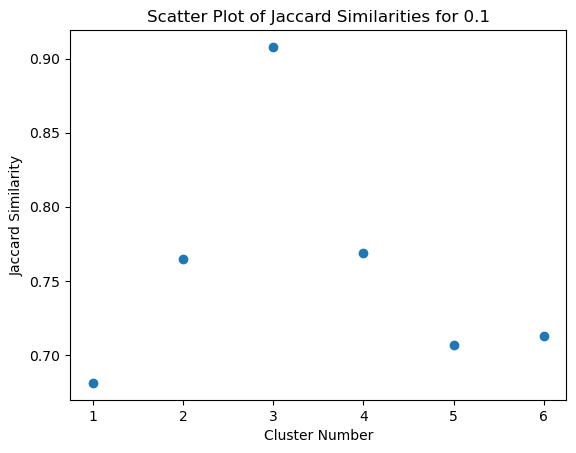

In [26]:
# Analysis comparison for 0.1
analysis(dict_pointone, '0.1')